Upload Dataset here

In [ ]:
#This code is to upload the data set from local drive into Colab
from google.colab import files
uploaded = files.upload()

Saving db_adults.csv to db_adults.csv


Multi-Freq-LDPy is a Python library for performing multiple frequency estimation tasks (one-time, multidimensional, longitudinal, and both) under local differential privacy (LDP) guarantees. The main goal is to provide an easy-to-use and fast execution toolkit to benchmark and experiment with state-of-the-art solutions and LDP protocols.


In [ ]:
!pip install multi-freq-ldpy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for multi-freq-ldpy: filename=multi_freq_ldpy-0.2.5-py3-none-any.whl size=46718 sha256=a2ac68eb560a31c8e65e78c430c65f06cc8e36d7538275778d8b4ab4f6f3bf3e
  Stored in directory: /root/.cache/pip/wheels/b5/e7/a7/79c888470e994c4a491caa16b9d8b5cbe8dd02b2d4f48e1b11
Successfully built multi-freq-ldpy


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
          'font.size':'14',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('font', family='serif')

import warnings; warnings.simplefilter('ignore')
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from multi_freq_ldpy.pure_frequency_oracles.GRR import GRR_Client, GRR_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.UE import UE_Client, UE_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.ADP import ADP_Client, ADP_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.LH import LH_Client, LH_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.SS import SS_Client, SS_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.HE import HE_Client, HE_Aggregator_MI

In [ ]:
df = pd.read_csv("/content/db_adults.csv", usecols=['age'])

In [ ]:
print(df.shape)

(45222, 1)


In [ ]:
#print(df.head(3))
df.head(5)

,age
0,39
1,50
2,38
3,53
4,28


lets take a look the Arguments

In [ ]:
def setup_args():
    args = {
        'user_num': 5000,       # the total number of users
        'trajectory_len': 6,    # the trajectory length
        'x_left': -45.0,        # set the scope of the 2-D geospatial domain
        'x_right': 85.0,
        'y_left': -160.0,
        'y_right': 160.0,
        'sigma': 0.2,           # the parameters in guideline
        'alpha': 0.02,
        'epsilon': 1.0,         # set the privacy budget
        'query_region_num': 225,  # 15 * 15 grid for Query MAE
        'FP_granularity': 15,     # 15 * 15 grid for FP Similarity
        'length_bin_num': 20,     # 20 bins for Distance Error
    }

    return args

# Example usage:
args = setup_args()
print('Epsilon =' ,args['epsilon'])  # Access individual parameters


Epsilon = 1.0


Lets take an example
Let us consider a set of 10 Values. we are going to select one data that is lets say 2. By keeping the epsilon value as 1. We are going to check the different LDP trajectory protocol to find out which is the best one.
Conclusion:
we can see that OLH and OUE gives similar privacy guarantee

In [ ]:
z = 10 # number of values
input_data = 2 # real input value
eps = 1 # privacy guarantee

print('Real value:', input_data)
print('Sanitization w/ GRR protocol:', GRR_Client(input_data, z, eps))
print('Sanitization w/ OUE protocol:', UE_Client(input_data, z, eps, optimal=True))
print('Sanitization w/ OLH protocol:', LH_Client(input_data, z, eps, optimal=True)) # sanitized value, seed used to hash
print('Sanitization w/ SS protocol:', SS_Client(input_data, z, eps)) # set of sanitized values
print('Sanitization w/ HE protocol:', HE_Client(input_data, z, eps)) # histogram with Laplace noise

Real value: 2
Sanitization w/ GRR protocol: 8
Sanitization w/ OUE protocol: [0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
Sanitization w/ OLH protocol: (1, 1801120179382175332)
Sanitization w/ SS protocol: [2 6 3]
Sanitization w/ HE protocol: [ 0.53295414  4.82137088  0.17600328 -1.22937244  2.00228177 -4.88503628
  1.13554785 -0.58973623 -0.51029723 -1.96815293]


Encoding the dataset

In [ ]:
LE = LabelEncoder()

df['age'] = LE.fit_transform(df['age'])
df.head(5)

,age
0,22
1,33
2,21
3,36
4,11


In [ ]:
# number of users (n)
n = df.shape[0]
print('Number of Users =',n)

# attribute's domain size
k = len(set(df['age']))
print("\nAttribute's domain size =", k)

print("\nPrivacy guarantees:")

# range of epsilon
lst_eps = np.arange(0.5, 5.1, 0.5)
print('Epsilon values =', lst_eps)

Number of Users = 45222

Attribute's domain size = 74

Privacy guarantees:
Epsilon values = [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


LDP trajectory protocols

In [ ]:
# Real normalized frequency
real_freq = np.unique(df, return_counts=True)[-1] / n

# Repeat nb_seed times since DP protocols are randomized
nb_seed = 20

# Save Mean Squared Error (MSE) between real and estimated frequencies per seed
dic_mse = {seed:
               {
                "SUE": [],
                "OUE": [],
                "BLH": [],
                "OLH": [],
                "SHE": []
               }
               for seed in range(nb_seed)
          }

starttime = time.time()
for seed in range(nb_seed):
    print('Starting w/ seed:', seed)

    for eps in lst_eps:


        # SUE protocol
        sue_reports = [UE_Client(input_data, k, eps, optimal=False) for input_data in df['age']]
        sue_est_freq = UE_Aggregator_MI(sue_reports, eps, optimal=False)
        dic_mse[seed]["SUE"].append(mean_squared_error(real_freq, sue_est_freq))

        # OUE protocol
        oue_reports = [UE_Client(input_data, k, eps, optimal=True) for input_data in df['age']]
        oue_est_freq = UE_Aggregator_MI(oue_reports, eps, optimal=True)
        dic_mse[seed]["OUE"].append(mean_squared_error(real_freq, oue_est_freq))

        # BLH protocol
        blh_reports = [LH_Client(input_data, k, eps, optimal=False) for input_data in df['age']]
        blh_est_freq = LH_Aggregator_MI(blh_reports, k, eps, optimal=False)
        dic_mse[seed]["BLH"].append(mean_squared_error(real_freq, blh_est_freq))

        # OLH protocol
        olh_reports = [LH_Client(input_data, k, eps, optimal=True) for input_data in df['age']]
        olh_est_freq = LH_Aggregator_MI(olh_reports, k, eps, optimal=True)
        dic_mse[seed]["OLH"].append(mean_squared_error(real_freq, olh_est_freq))


        # SHE protocol
        he_reports = [HE_Client(input_data, k, eps) for input_data in df['age']]
        she_est_freq = HE_Aggregator_MI(he_reports, k, eps, use_thresh=False)
        dic_mse[seed]["SHE"].append(mean_squared_error(real_freq, she_est_freq))


print('That took {} seconds'.format(time.time() - starttime))

Starting w/ seed: 0
Starting w/ seed: 1
Starting w/ seed: 2
Starting w/ seed: 3
Starting w/ seed: 4
Starting w/ seed: 5
Starting w/ seed: 6
Starting w/ seed: 7
Starting w/ seed: 8
Starting w/ seed: 9
Starting w/ seed: 10
Starting w/ seed: 11
Starting w/ seed: 12
Starting w/ seed: 13
Starting w/ seed: 14
Starting w/ seed: 15
Starting w/ seed: 16
Starting w/ seed: 17
Starting w/ seed: 18
Starting w/ seed: 19
That took 1697.99253988266 seconds


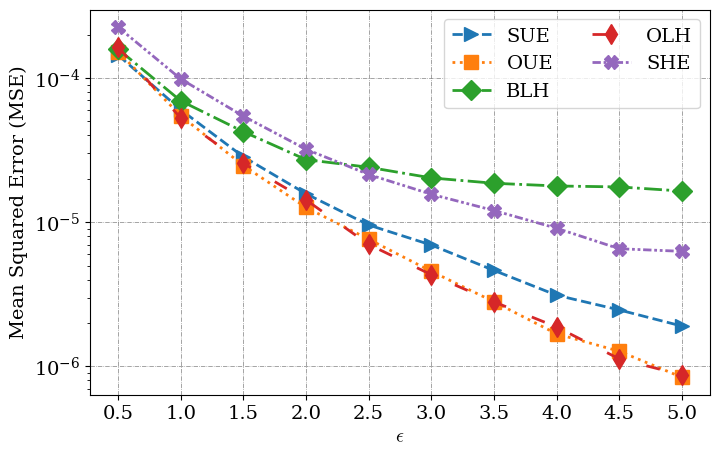

In [13]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
#plt.plot(np.mean([dic_mse[seed]["GRR"] for seed in range(nb_seed)], axis=0), label='GRR', marker='o')
#plt.plot(np.mean([dic_mse[seed]["SS"] for seed in range(nb_seed)], axis=0), label='SS',marker='X',linestyle=(0, (1, 10)))
plt.plot(np.mean([dic_mse[seed]["SUE"] for seed in range(nb_seed)], axis=0), label='SUE',marker='>',linestyle='dashed')
plt.plot(np.mean([dic_mse[seed]["OUE"] for seed in range(nb_seed)], axis=0), label='OUE',marker='s',linestyle='dotted')
plt.plot(np.mean([dic_mse[seed]["BLH"] for seed in range(nb_seed)], axis=0), label='BLH', marker='D', linestyle='dashdot')
plt.plot(np.mean([dic_mse[seed]["OLH"] for seed in range(nb_seed)], axis=0), label='OLH',marker='d',linestyle=(0, (5, 10)))
plt.plot(np.mean([dic_mse[seed]["SHE"] for seed in range(nb_seed)], axis=0), label='SHE',marker='X',linestyle=(0, (3, 1, 1, 1, 1, 1)))

plt.yscale('log')
plt.xlabel('$\epsilon$')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(range(len(lst_eps)), lst_eps)
plt.legend(ncol=2)
plt.show()

Clone the github repository

In [ ]:
!git clone https://github.com/Lonelypheonix/PrivTC-Implementation.git

Cloning into 'PrivTC-Implementation'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 69 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (69/69), 346.34 KiB | 2.15 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
%cd /content/PrivTC-Implementation/Code/

/content/PrivTC-Implementation/Code


PrivTc Under epsilon 1

In [ ]:
%run Privtc.py

PrivTC starts...
PrivTC ends!

The results are: 
Query MAE: 0.006429037037037037
FP similarity: 0
Distance Error: 0.9882915830689873
That took 4.124042510986328 seconds


Privtc For a range of Epsilon


PrivTC starts for Epsilon=0.5...
PrivTC ends!
Query MAE (Epsilon=0.5): 0.007319703703703703
FP Similarity (Epsilon=0.5): 0.01
Distance Error (Epsilon=0.5): 0.9914073449699317

PrivTC starts for Epsilon=1.0...
PrivTC ends!
Query MAE (Epsilon=1.0): 0.008724740740740741
FP Similarity (Epsilon=1.0): 0.01
Distance Error (Epsilon=1.0): 0.9801078750375605

PrivTC starts for Epsilon=1.5...
PrivTC ends!
Query MAE (Epsilon=1.5): 0.006308740740740741
FP Similarity (Epsilon=1.5): 0.20999999999999996
Distance Error (Epsilon=1.5): 0.9576698073517309

PrivTC starts for Epsilon=2.0...
PrivTC ends!
Query MAE (Epsilon=2.0): 0.006808888888888889
FP Similarity (Epsilon=2.0): 0.04
Distance Error (Epsilon=2.0): 0.973542832408913

PrivTC starts for Epsilon=2.5...
PrivTC ends!
Query MAE (Epsilon=2.5): 0.005856
FP Similarity (Epsilon=2.5): 0.25
Distance Error (Epsilon=2.5): 0.948547404262192

PrivTC starts for Epsilon=3.0...
PrivTC ends!
Query MAE (Epsilon=3.0): 0.004646222222222223
FP Similarity (Epsilon=3.0

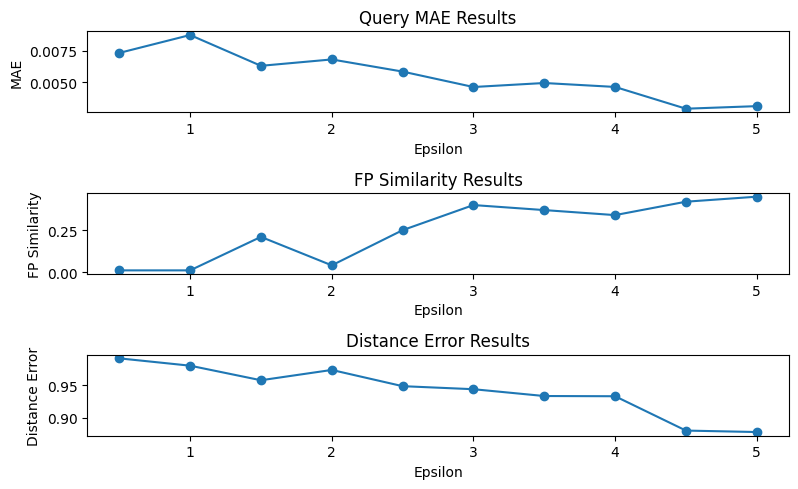

That took 1464.3505840301514 seconds


<Figure size 640x480 with 0 Axes>

In [ ]:
%run Privtc_eps.py